# QES Multi Factor Analysis


This examples illustrates multi-factor analysis using analytics library. It shows the following steps:

- Downloading data from the platform
- Interfacing with the analytics library
- Neutralizing the factor
- Using different weighting schemes
  - Equi-weighted
  - Risk-parity weighting
  - Inverse-vol weighting
  - Specified weighting
  

## Initializing the Data Query Engine using LQuant Database

In [1]:
## lquant package library provides access to the data querying as well as analytics functions
try:
    from lquantPy import LQuant
    wq = LQuant.LQuant()                                       # wq is LQuant tool handler

except Exception as e:
    if str(e).startswith("VM is already running"):
        print ("LQuant is already initialized!")
    else:
        print (e)
        
#Please restart notebook and run this code block again in case there is an error

2023-06-22 19:15:50,560 - lquantPy.LQuant - INFO - Initial LQuant. This may take some time...
2023-06-22 19:15:50,562 - lquantPy.LQuant - INFO - Initialized LQuant environment
2023-06-22 19:15:50,563 - lquantPy.LQuant - INFO - Initializing LQuant, This will take some time....


Library Path -Djava.library.path=/usr/local/lib/R/site-library/rJava/jri


# Querying the data from LQuant

Lquant Query API allows access to several universes, factors (z-normal). The query api allows users to download data to memory and perform analytics. The data returned from lquant has three dimensions:

1. Factors (K)
2. Securities (N)
3. Dates (M)


### Initialize the list of factors to query 

In [2]:
# Define Factors to load

#alpha factors are mainly used to generate excess market returns
alpha_factors = [  'EPSYLD_NTM',
                   'CFOYLD_FY1',
                   'DEBT_ASSET',         # Total Debt / Total Assets
                   'DEBT_EBIT',          # Debt / EBIT
                   'ES_EPS_NTM_R3M',     # 3-months earnings revisions
                   'ES_SALE_NTM_R3M',    # 3-months revenue revisions
                   'REAL_VOL',           # 1-year volatility (lower is better, standard deviation of daily returns over 252 days) 
                   'RTN12M',             # 1-year trend (252-day total return – price and dividend incorporate of total return)        
          ]


all_factors = alpha_factors 

### LQuant APIs to query factors data

In [3]:
univ = 'CIQMSCI_379978898'                                 # Mnemonic for MSCI World Universe: CIQMSCI_379978898
start_date = '2012-06-01'
end_date = '2022-07-01'
freq = '1me'                                               # For every month end (it can be '1d', '1w' or '1m')

wq.env().run('library(lqrisk)')
req = wq.new_request()                                     # New data request

req = req.runFor(univ)                                     # MSCI World: CIQMSCI_379978898
                                                           # Run for TQAMSCI_984000(MSCI US)
                                                           # Please use following mnemonic to load data
                                                           # MSCI World ex-US: TQAMSCI_991000 
                                                           # US: TQAMSCI_984000 
                                                           # EM: TQAMSCI_891800 
                                                        

req = req.start(start_date).to(end_date)                   # From start date to end date
req = req.at(freq)                                         # For every month end (it can be 1d, 1w or 1m)

req = req.attr(*tuple(all_factors))                        # Add all factors to data request
req = req.a('QES_COUNTRY')                                 # Or you can add one factor
req = req.a('QES_GSECTOR')                                 # Here we are adding 2 character GICS cocxe
req = req.a('COMPANYNAME')
req = req.a('SEDOL')
req = req.a('TICKER')


req = req.addForwardReturn()                               # Add forward return
req = req.addInFlag()                                      # Add in universe flag

data = wq.get_data(req)                                    # Execute data

2023-06-22 19:16:55,358 - lquantPy.LQuant - INFO - Fetching Data


In [4]:
data

data_1:List of 17 elements [[EPSYLD_NTM, CFOYLD_FY1, DEBT_ASSET, DEBT_EBIT, ES_EPS_NTM_R3M, ES_SALE_NTM_R3M, REAL_VOL, RTN12M, QES_COUNTRY, QES_GSECTOR, COMPANYNAME, SEDOL, TICKER, PRCCD, CUM_DIV, IN_CIQMSCI_379978898, FRTN1P]]

In [20]:
data

data_1:List of 17 elements [[EPSYLD_NTM, CFOYLD_FY1, DEBT_ASSET, DEBT_EBIT, ES_EPS_NTM_R3M, ES_SALE_NTM_R3M, REAL_VOL, RTN12M, QES_COUNTRY, QES_GSECTOR, COMPANYNAME, SEDOL, TICKER, PRCCD, CUM_DIV, IN_CIQMSCI_379978898, FRTN1P]]

In [19]:
ticker.loc['170617.01']

2012-06-30    Meta Platforms Inc
2012-07-31    Meta Platforms Inc
2012-08-31    Meta Platforms Inc
2012-09-30    Meta Platforms Inc
2012-10-31    Meta Platforms Inc
2012-11-30    Meta Platforms Inc
2012-12-31    Meta Platforms Inc
2013-01-31    Meta Platforms Inc
2013-02-28    Meta Platforms Inc
2013-03-31    Meta Platforms Inc
2013-04-30    Meta Platforms Inc
2013-05-31    Meta Platforms Inc
2013-06-30    Meta Platforms Inc
2013-07-31    Meta Platforms Inc
2013-08-31    Meta Platforms Inc
2013-09-30    Meta Platforms Inc
2013-10-31    Meta Platforms Inc
2013-11-30    Meta Platforms Inc
2013-12-31    Meta Platforms Inc
2014-01-31    Meta Platforms Inc
2014-02-28    Meta Platforms Inc
2014-03-31    Meta Platforms Inc
2014-04-30    Meta Platforms Inc
2014-05-31    Meta Platforms Inc
2014-06-30    Meta Platforms Inc
2014-07-31    Meta Platforms Inc
2014-08-31    Meta Platforms Inc
2014-09-30    Meta Platforms Inc
2014-10-31    Meta Platforms Inc
2014-11-30    Meta Platforms Inc
          

In [4]:
#convert factor data as dataframe
data_df = data.as_large_data_frame()

In [7]:
data_df[['DATE', 'TICKER',  'IN_' + univ]].head()

,DATE,TICKER,IN_CIQMSCI_379978898
0,2012-06-30,SSNC,NaN
1,2012-06-30,GNW,1.0
2,2012-06-30,GM,1.0
3,2012-06-30,ALNY,NaN
4,2012-06-30,CBG,1.0


### Test the Improvement in Coverage of Analyst Expectation Factors

# Factor Processing 

### Create Point-in-time Investment Universe

In [8]:
# This returns a handle to multi-factor analysis class
analytics = wq.multi_factor_analysis(data,  'IN_' + univ)

# Masking is needed to ensure we only keep factors in universe as non-NA
analytics.mask_factors(all_factors)

### Check Coverage of Factors in the Investment Universe

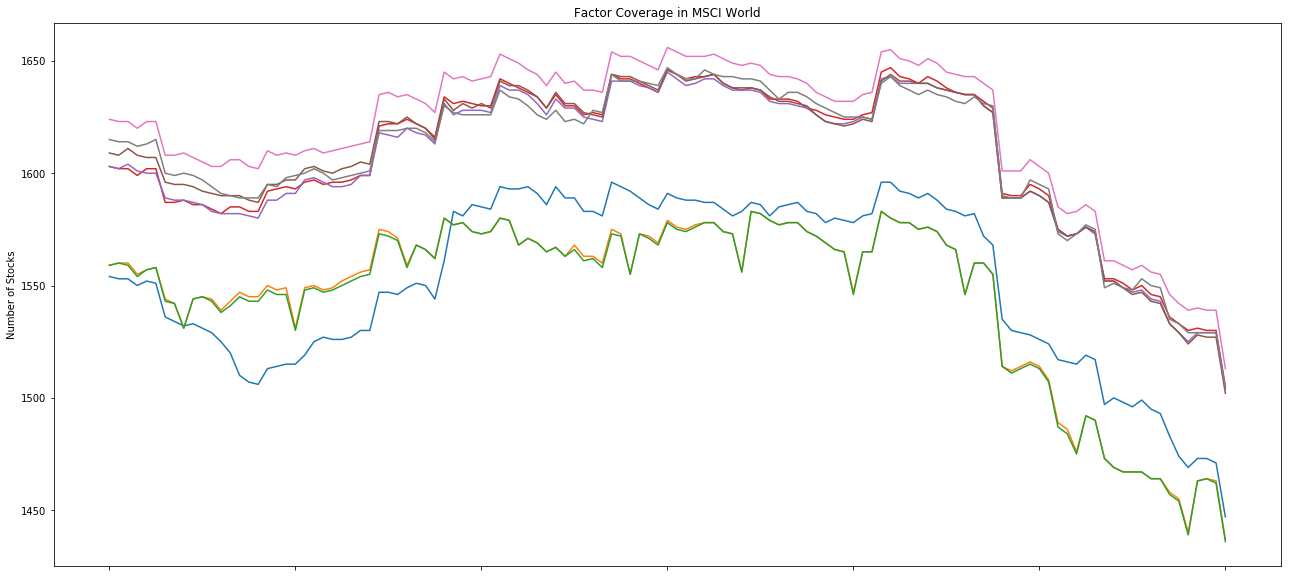

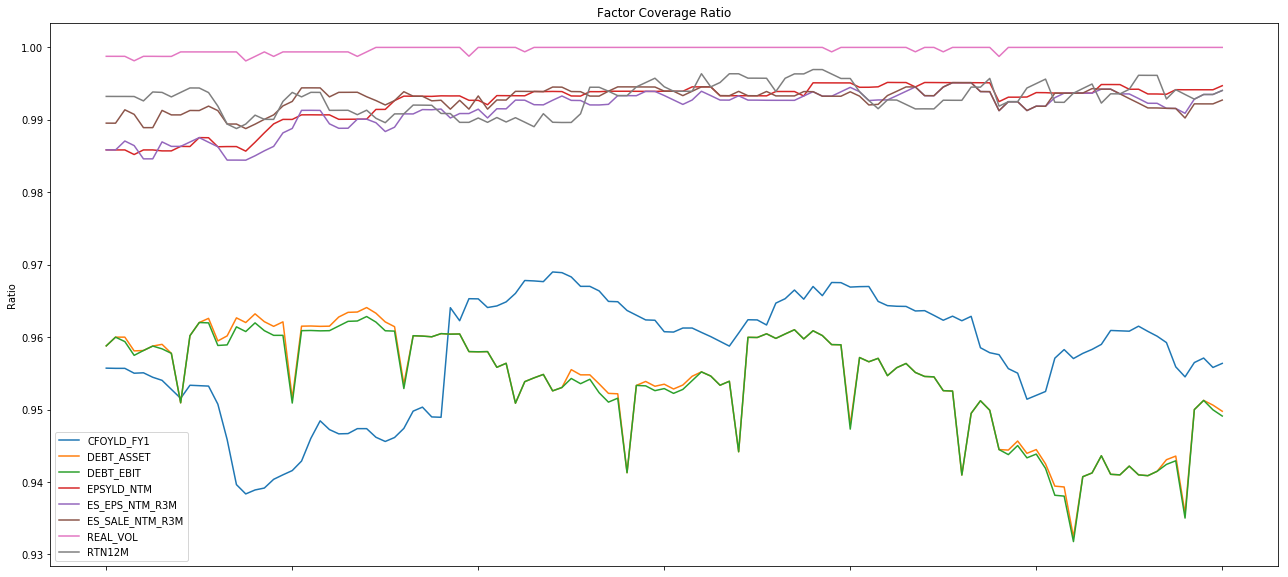

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
coverage = pd.DataFrame({factor: data[factor].as_matrix().count() for factor in all_factors}) 
coverage_ratio = pd.DataFrame({factor: data[factor].as_matrix().count()/data['IN_' + univ].as_matrix().sum() for factor in all_factors}) # ratio of factor available
#%matplotlib inline 
coverage.plot(title='Factor Coverage in MSCI World', figsize=(22, 10), legend=None)
plt.ylabel("Number of Stocks")
plt.show()

coverage_ratio.plot(title='Factor Coverage Ratio', figsize=(22, 10))
plt.ylabel("Ratio")
plt.show()


### Country Neutralization

Factor are neutralized within each Country since the Investment Universe is Global. Each neutralized variable is stored in the data object with the name specified as the first parameter

In [15]:
# Neutralize all factors
for ff in all_factors:   
    print('Neutralizing Factor ' + ff)
    analytics.basic_neutralize_factor('Neut_' + ff,ff,'z_normal','QES_COUNTRY')

Neutralizing Factor EPSYLD_NTM
Neutralizing Factor CFOYLD_FY1
Neutralizing Factor DEBT_ASSET
Neutralizing Factor DEBT_EBIT
Neutralizing Factor ES_EPS_NTM_R3M
Neutralizing Factor ES_SALE_NTM_R3M
Neutralizing Factor REAL_VOL
Neutralizing Factor RTN12M


#### Redefine factor names as Neutralized factors

In [22]:
factors = ['Neut_' + ff for ff in all_factors]

In [23]:
factors

['Neut_EPSYLD_NTM',
 'Neut_CFOYLD_FY1',
 'Neut_DEBT_ASSET',
 'Neut_DEBT_EBIT',
 'Neut_ES_EPS_NTM_R3M',
 'Neut_ES_SALE_NTM_R3M',
 'Neut_REAL_VOL',
 'Neut_RTN12M']

In [25]:
data

data_1:List of 25 elements [[EPSYLD_NTM, CFOYLD_FY1, DEBT_ASSET, DEBT_EBIT, ES_EPS_NTM_R3M, ES_SALE_NTM_R3M, REAL_VOL, RTN12M, QES_COUNTRY, QES_GSECTOR, COMPANYNAME, SEDOL, TICKER, PRCCD, CUM_DIV, IN_CIQMSCI_379978898, FRTN1P, Neut_EPSYLD_NTM, Neut_CFOYLD_FY1, Neut_DEBT_ASSET, Neut_DEBT_EBIT, Neut_ES_EPS_NTM_R3M, Neut_ES_SALE_NTM_R3M, Neut_REAL_VOL, Neut_RTN12M]]

#### Inverting Vol, Debt to Asset, and Debt to Ebit as it is descending factor

In [26]:
analytics.invert_factors(factors = ['Neut_REAL_VOL']) #you want to long low vol stocks and short high vol stocks

True

In [27]:
analytics.invert_factors(factors = ['Neut_DEBT_EBIT']) 

True

In [28]:
analytics.invert_factors(factors = ['Neut_DEBT_ASSET']) 

True

# Multi-factor Weighting and Composite factor construction

We have a python class that helps with doing different weightings. Prior to weighting the factor, we neutralize the factor. Here we demonstrate 4 different types of weighting

- Inverse Vol Weighted
- Risk Parity Weighted
- Equi Weighted
- Specified Constant Weighted

## 1. Inverse Volatility Weighting

Assigns more (less) weight to factor having lower (higher) standard deviation of Rank IC. Intuitively, a factor having high variability in predicting the future returns gets less weight and vice versa.

\begin{equation} 
\begin{split}
&\Large w_{i, t} = \frac{\frac{1}{\sigma_{i, t}}}{\sum_{j=1}^{K} \frac{1}{\sigma_{j, t}}}, \\ \\
&\large \sigma_{i, t} = Standard\ Deviation\ of\ Rank\ IC\ of\ Factor\ i
\end{split}
\end{equation}

In [29]:
# Vol weighting functions takes the set of factors as input. 
volWeights = analytics.get_vol_weights('volWeights',factors)
volWeights.as_matrix()

,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
Neut_EPSYLD_NTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.080464,0.081385,0.082043,0.081021,0.076280,0.076334,0.076562,0.076752,0.075027,0.075677
Neut_CFOYLD_FY1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.085766,0.086725,0.087749,0.086571,0.079589,0.079241,0.079492,0.079783,0.078245,0.078465
Neut_DEBT_ASSET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.204737,0.204285,0.206063,0.204800,0.211303,0.211144,0.210272,0.204353,0.203869,0.204987
Neut_DEBT_EBIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.156107,0.155747,0.153538,0.156782,0.151964,0.151907,0.152777,0.154808,0.156245,0.157292
Neut_ES_EPS_NTM_R3M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.155377,0.156130,0.154981,0.156220,0.161975,0.162023,0.162074,0.165484,0.165999,0.165413
Neut_ES_SALE_NTM_R3M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.159639,0.158881,0.158406,0.158381,0.157586,0.157778,0.158181,0.159158,0.159350,0.157977
Neut_REAL_VOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.078426,0.078059,0.077976,0.076714,0.079133,0.079300,0.079197,0.077308,0.078575,0.077099
Neut_RTN12M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.079483,0.078789,0.079244,0.079510,0.082170,0.082274,0.081444,0.082354,0.082689,0.083090


The matrix returned by vol weight function is K x T, where K is number of factors and T is the number of time period

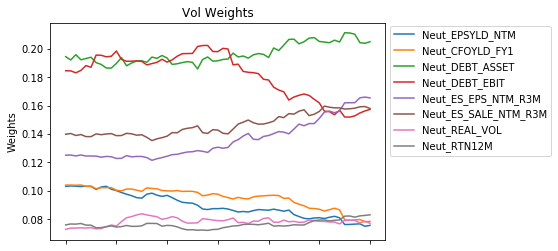

In [30]:
volWeights.as_matrix().transpose().plot()
plt.legend(bbox_to_anchor=(1.0, 1.01))
plt.title('Vol Weights')
plt.ylabel('Weights')
plt.show()

We can then use these weights to compute the composites. Compute the weights using the vol weighting above. In below code, the composite is created (VolWeightedScore) using a weighted average of all the factor weights derived from Inverse Volatility Weighting. 

\begin{equation} 
\begin{split}
&\large w\_comp_{t} = \frac{\sum_{i=1}^{K} w_{i,t} * f_{i, t} }{\sum_{i=1}^{K} w_{i,t}}
\end{split}
\end{equation}


In [31]:
x1 = analytics.multi_factor_score('VolWeightedScore',factors,'volWeights')
data.element('VolWeightedScore').as_matrix().head()

,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
062965.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.029479,0.101147,0.125454,0.111388,-0.108223,-0.049321,-0.029007,0.167482,0.140568,0.153189
158354.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005073.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.222664,0.455271,0.610530,0.902797,0.564056,0.896436,0.747410,0.709584,0.262861,0.296529
264265.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.162824,-0.141683,0.223014,0.201597,-0.095828,-0.019978,0.037225,-0.487747,-0.156336,-0.204671
260774.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.232044,0.399602,0.357203,0.447591,-0.044259,0.242491,0.159497,0.043823,-0.275138,-0.179207


## 2. Risk Parity Weighting

## 2.1 Definition of marginal and total risk contributions

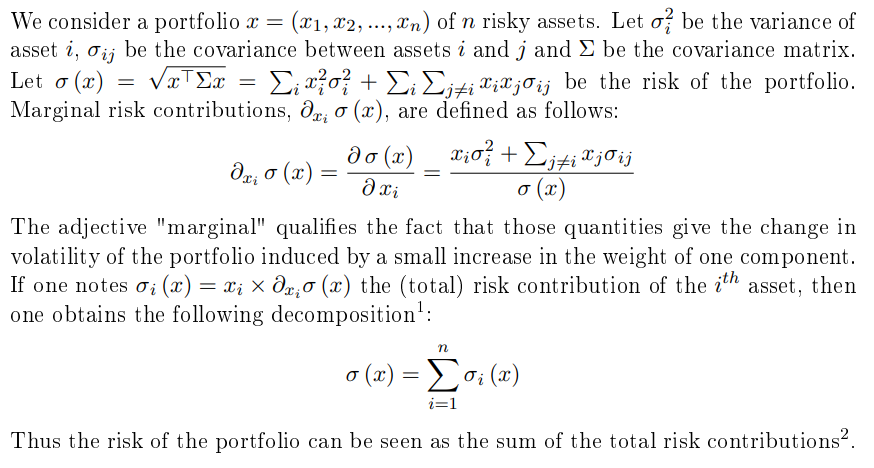

## 2.2 Specification of the Equal Risk Contribution (ERC) strategy

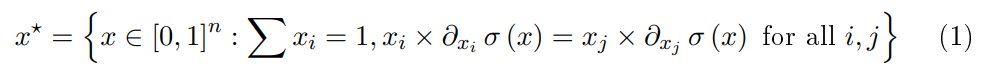

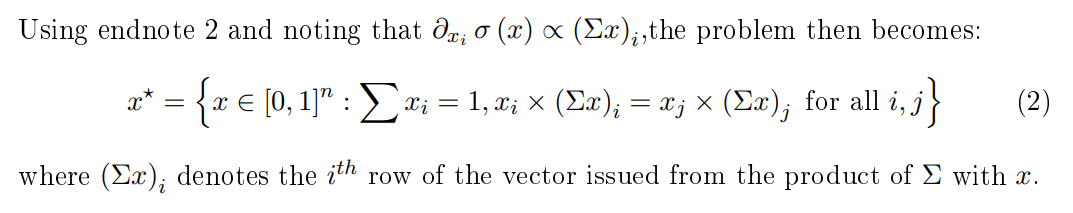

## 2.3 Numerical solutions to the ERC strategy

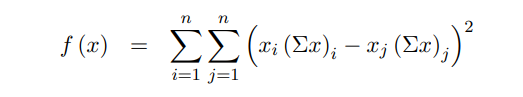

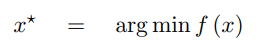

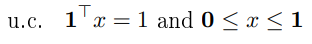

In [32]:
# Risk parity weights take a bit longer as a complete covariance matrix
# is constructed for the investment universe. This is done over each rebalance period
riskParityWeights = analytics.get_risk_parity_weights_ic('riskParityWeights',factors)

In [33]:
riskParityWeights.as_matrix()

,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
Neut_EPSYLD_NTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.105730,0.105626,0.106079,0.103118,0.091250,0.088229,0.088723,0.084470,0.082962,0.082532
Neut_CFOYLD_FY1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.074636,0.074465,0.074879,0.073343,0.066280,0.067088,0.066579,0.066800,0.065713,0.065080
Neut_DEBT_ASSET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.296225,0.294704,0.297849,0.294954,0.291731,0.291789,0.287757,0.278230,0.278168,0.281123
Neut_DEBT_EBIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.086048,0.086185,0.084512,0.086724,0.084063,0.083797,0.084568,0.086746,0.087026,0.093575
Neut_ES_EPS_NTM_R3M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.068598,0.068784,0.068450,0.068036,0.067875,0.067841,0.068886,0.070552,0.069497,0.070331
Neut_ES_SALE_NTM_R3M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.151945,0.153152,0.153778,0.154684,0.165237,0.165115,0.170748,0.176668,0.177986,0.165054
Neut_REAL_VOL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.094948,0.094961,0.093141,0.097370,0.111890,0.113862,0.114629,0.120810,0.124338,0.121205
Neut_RTN12M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.121869,0.122123,0.121311,0.121771,0.121673,0.122280,0.118109,0.115725,0.114310,0.121099


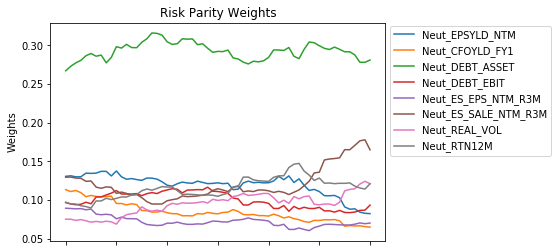

In [34]:
riskParityWeights.as_matrix().transpose().plot()
plt.legend(bbox_to_anchor=(1.0, 1.01))
plt.title('Risk Parity Weights')
plt.ylabel('Weights')
plt.show()

In [35]:
x1 = analytics.multi_factor_score('RiskParityWeightedScore',factors,'riskParityWeights')

# You can extract the weights as pandas data frame using as_matrix
data.element('RiskParityWeightedScore').as_matrix().head()

,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
062965.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.038928,0.079555,0.082184,0.073417,-0.109545,-0.061988,-0.055391,0.167385,0.163385,0.174638
158354.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005073.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.458912,0.641260,0.664554,0.856207,0.537864,0.748870,0.659659,0.608661,0.303777,0.325833
264265.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.211320,-0.251996,0.315755,0.293259,0.029936,0.316132,0.378724,-0.183352,0.098764,0.105784
260774.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.196531,0.340289,0.292877,0.393484,-0.009812,0.141108,0.077956,-0.018418,-0.283863,-0.216879



## 3. Equi-weighted

In [36]:
x1 = analytics.multi_factor_score('EquiWeightedScore',
                                      factors,
                                     [1/len(factors)] * len(factors))

# You can extract the weights as pandas data frame using as_matrix
data.element('EquiWeightedScore').as_matrix().head()


,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
062965.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.074846,0.047342,0.062490,0.059143,-0.139224,-0.076350,-0.057663,0.101987,0.095952,0.104409
158354.01,0.023454,0.440074,0.320931,0.328517,0.481771,0.510036,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005073.19,0.145592,0.110513,0.184431,0.127317,0.464717,0.216692,0.353455,0.016229,0.679048,0.523169,...,0.443399,0.588138,0.689286,0.949261,0.636202,0.918574,0.790279,0.769859,0.425844,0.446267
264265.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.098677,-0.309814,0.005927,-0.024089,-0.373123,-0.269127,-0.197191,-0.538053,-0.385574,-0.406243
260774.01,0.350590,0.487156,0.705996,0.702621,0.489788,0.147532,0.148110,0.031846,0.653901,0.676383,...,0.282758,0.438186,0.378780,0.506105,0.114295,0.313609,0.236634,0.125086,-0.110324,-0.041873


## 4. Specified Weights

In [39]:
x1 = analytics.multi_factor_score('SpecifiedWeightedScore',
                                      factors,
                                     [0.03, 0.05, 0.17, 0.02, 0.18, 0.15, 0.1, 0.2, 0.16, 0.04])

# You can extract the weights as pandas data frame using as_matrix
data.element('SpecifiedWeightedScore').as_matrix().head()




,2012-06-30,2012-07-31,2012-08-31,2012-09-30,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,...,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30
062965.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.268140,-0.054634,-0.051980,-0.057474,-0.225266,-0.151175,-0.153324,-0.046632,-0.073218,-0.061210
158354.01,-0.713827,-0.134216,-0.261882,-0.25671,-0.020131,0.053322,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005073.19,-0.390355,-0.439606,-0.307936,-0.37213,0.129852,-0.147841,0.056012,-0.444255,0.099526,-0.151337,...,0.067661,0.209694,0.395502,0.708127,0.197646,0.476970,0.271028,0.255059,-0.203076,-0.167871
264265.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.403630,0.208009,0.552799,0.446084,-0.067973,0.064840,0.178470,-0.201781,-0.088878,-0.094731
260774.01,0.140868,0.295808,0.682518,0.70375,0.419735,0.060933,0.124408,-0.044795,0.719400,0.744213,...,0.519983,0.615660,0.514710,0.689489,0.157697,0.370167,0.225135,0.067116,-0.257677,-0.156280


In [40]:
df = data.as_large_data_frame()
### Converting all data to pandas
df.to_csv('Multi-Factor-MSCI-World.csv',index=False)

<i>MSCI_US_Weights.csv</i> should be available in Jupyter home. It can be downloaded by clicking on the file and then use the Save option. 

## Backtesting all Factors including Composites

Each factor can be independently backtested or several factors can be backtested together. 

In [42]:
# Select factors to backtest
aggregate_factors = ['VolWeightedScore','RiskParityWeightedScore','EquiWeightedScore','SpecifiedWeightedScore']
all_active_factors = factors + aggregate_factors
NUM_BINS = 5


# The below code will backtest all the factors 
# Arg1 List of factors
# Arg2 Number of Bins for backtest
backtest_results = analytics.backtest(all_active_factors, bins = NUM_BINS, align = False)

In [43]:
backtest_results.get_summary()

,CAGR (% Annualized Return),Coverage (Median # Tickers),Maximum Drawdown,Rank IC(%),Sharpe Ratio,Turnover(%),Volatility(%)
Neut_EPSYLD_NTM,2.361,1624.0,-37.967,1.535,0.194,20.557,12.155
Neut_CFOYLD_FY1,-0.287,1554.0,-48.238,-0.148,-0.022,19.464,13.030
Neut_DEBT_ASSET,-1.009,1560.0,-19.356,-0.781,-0.231,10.061,4.363
Neut_DEBT_EBIT,-1.591,1560.0,-35.267,-1.053,-0.228,12.461,6.992
Neut_ES_EPS_NTM_R3M,4.664,1620.0,-9.897,1.493,0.620,63.822,7.529
Neut_ES_SALE_NTM_R3M,0.633,1622.0,-13.360,0.306,0.091,65.220,6.959
Neut_REAL_VOL,-2.138,1634.0,-35.200,-0.929,-0.150,18.120,14.264
Neut_RTN12M,1.794,1620.0,-29.011,0.913,0.138,47.703,13.034
VolWeightedScore,-0.064,1636.0,-23.406,-0.172,-0.008,20.768,7.899
RiskParityWeightedScore,-0.503,1636.0,-20.276,-0.216,-0.074,17.406,6.781


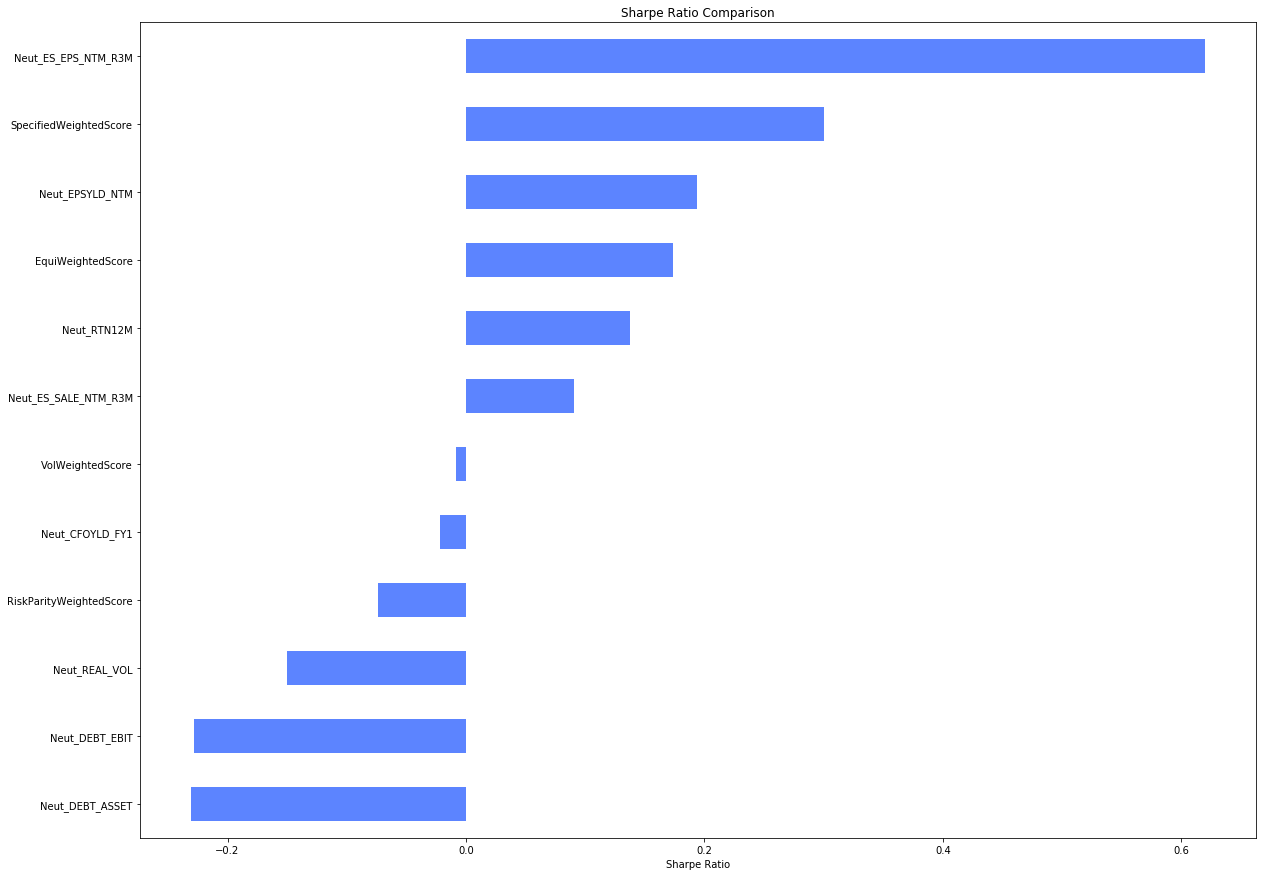

In [44]:
backtest_results.get_summary().sort_values('Sharpe Ratio')['Sharpe Ratio'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison")
plt.show()

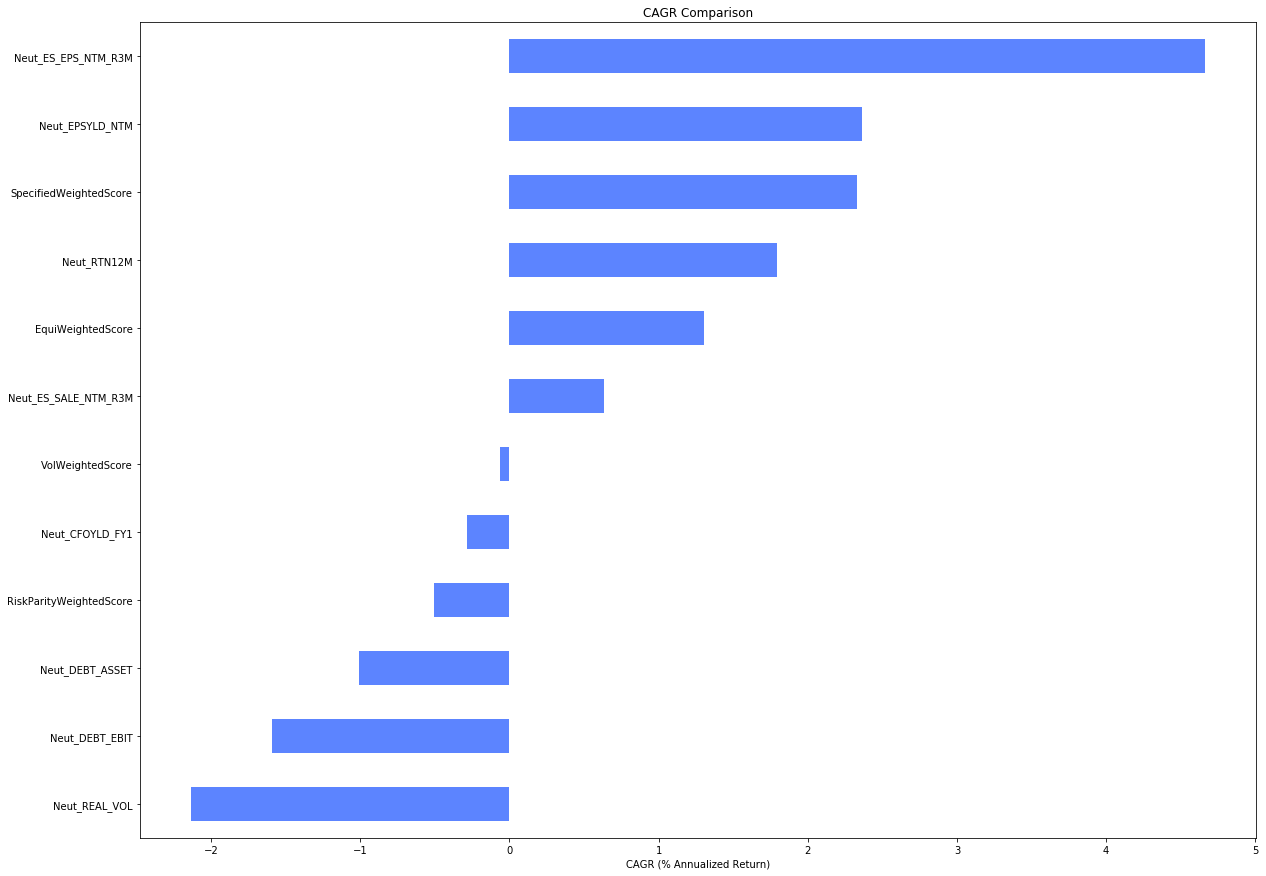

In [45]:
backtest_results.get_summary().sort_values('CAGR (% Annualized Return)')['CAGR (% Annualized Return)'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("CAGR (% Annualized Return)")
plt.title("CAGR Comparison")
plt.show()

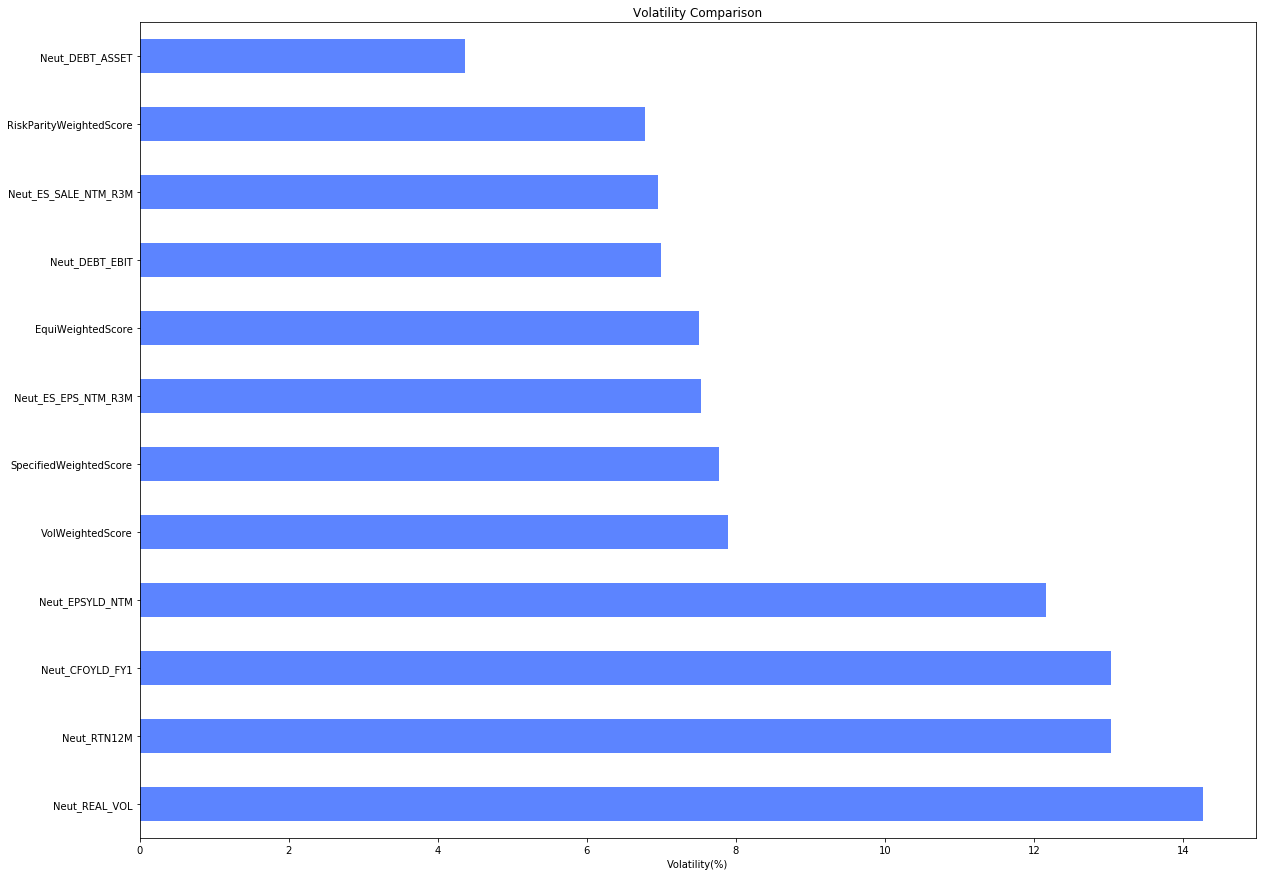

In [46]:
backtest_results.get_summary().sort_values('Volatility(%)', ascending = False)['Volatility(%)'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("Volatility(%)")
plt.title("Volatility Comparison")
plt.show()

In [ ]:
backtest_results.get_summary().sort_values('Rank IC(%)')['Rank IC(%)'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("Rank IC(%)")
plt.title("Rank IC Comparison")
plt.show()

In [ ]:
backtest_results.get_summary().sort_values('Turnover(%)', ascending = False)['Turnover(%)'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("Turnover(%)")
plt.title("Turnover Comparison")
plt.show()

In [ ]:
backtest_results.get_summary().sort_values('Maximum Drawdown')['Maximum Drawdown'].plot(kind='barh', alpha=.8, color='#3366FF', figsize=(20, 15))
plt.xlabel("Maximum Drawdown")
plt.title("Maximum Drawdown Comparison")
plt.show()

### Generate Excel File with Factor Statistics

Backtest result class provides a simple function to generate an Excel with key metrics of the backtesting in once place

- Coverage (Aggregate and over Time)
- Long/Short Performance 
- Turnover (Average and over Time)
- CAGR (Several Period)
- Sharpe Ratio
- IC

In [ ]:
# Arg1: Name of the Universe
# Arg2: Number of baskets in the backtest
backtest_results.generate_excel('MSCI-World_All-Factors_20220708',NUM_BINS)
#backtest_results_aggr.generate_excel('MSCI-World_Aggregate-Factors_20220704',NUM_BINS)

The above code will generate a file at the current working directory
- Backtest_Stats_MSCI US Index_5_M.xlsx
The file can be downloaded by going to Jupyter home directory and clicking on this file. 

### Access Backtest Metrics from the Results object

In [ ]:
# Below function is getting the first backtest object and outputting the wealth curves for each quintile and long/short 
# basket
print('Quintile Wealth Curve Long/Short Vol Weighted Baskets')
backtest_results.get(0).wealth().as_matrix()